In [37]:
import os
from PIL import Image
import pandas as pd
import shutil
from labels import draw_bbox
import cv2
from PIL import Image
import numpy as np
import os

In [38]:
# Đường dẫn đến các thư mục chứa hình ảnh
train_image_folders = ['../dataset/Traffic Sign Detection/train',
                       '../dataset/Traffic Sign Detection/test',
                       '../dataset/Traffic Sign Detection/valid',
                       '../dataset/V2 - Traffic Signs/train',
                       '../dataset/V2 - Traffic Signs/valid',
                       '../dataset/TrafficSignLocalizationandDetection/train',
                       '../dataset/TrafficSignLocalizationandDetection/test',
                       '../dataset/TrafficSignLocalizationandDetection/valid',
                       ]
test_val_image_folders = ['../dataset/Vietnam Traffic Signs/train',
                          '../dataset/Vietnam Traffic Signs 2/train',
                          '../dataset/Vietnam Traffic Signs 2/valid',
                          '../dataset/Vietnam Traffic Signs 2/test',
                          ]
target_ouput='../dataset/detection'
size=640

In [39]:
def read_image(image_folders):
    # Tạo một danh sách để lưu thông tin về hình ảnh
    image_data = []
    print(len(image_folders))
    # Lặp qua các thư mục và đọc hình ảnh
    for folder in image_folders:
        if not os.path.exists(folder):
            print(f"Đường dẫn không tồn tại: {folder}")
        else:
            print(f"Đọc hình ảnh từ: {folder}")
        image_folder = f'{folder}/images'
        for filename in os.listdir(image_folder):
            if filename.endswith('.jpg') or filename.endswith('.png'):  # Chỉ đọc file ảnh
                img_path = os.path.join(image_folder, filename)
                img = Image.open(img_path)
                #check size of image
                width, height = img.size
                label_path = f'{folder}/labels/{filename[:-4]}.txt'
                # Kiểm tra xem file nhãn có tồn tại không
                if not os.path.exists(label_path):
                    print(f"File nhãn không tồn tại: {label_path}. Bỏ qua.")
                    continue
                image_data.append(
                    {'filename': filename,
                     'image_path': f'{image_folder}/{filename}',
                     'label_path': label_path,
                     'width': width,
                     'height': height}
                )

    # Chuyển danh sách thành DataFrame
    df = pd.DataFrame(image_data)
    return df

In [40]:
train_df = read_image(train_image_folders)
valid_df = read_image(test_val_image_folders)
train_df.shape, valid_df.shape

8
Đọc hình ảnh từ: ../dataset/Traffic Sign Detection/train
Đọc hình ảnh từ: ../dataset/Traffic Sign Detection/test
Đọc hình ảnh từ: ../dataset/Traffic Sign Detection/valid
Đọc hình ảnh từ: ../dataset/V2 - Traffic Signs/train
Đọc hình ảnh từ: ../dataset/V2 - Traffic Signs/valid
Đọc hình ảnh từ: ../dataset/TrafficSignLocalizationandDetection/train
Đọc hình ảnh từ: ../dataset/TrafficSignLocalizationandDetection/test
Đọc hình ảnh từ: ../dataset/TrafficSignLocalizationandDetection/valid
4
Đọc hình ảnh từ: ../dataset/Vietnam Traffic Signs/train
Đọc hình ảnh từ: ../dataset/Vietnam Traffic Signs 2/train
Đọc hình ảnh từ: ../dataset/Vietnam Traffic Signs 2/valid
Đọc hình ảnh từ: ../dataset/Vietnam Traffic Signs 2/test


((11088, 5), (4386, 5))

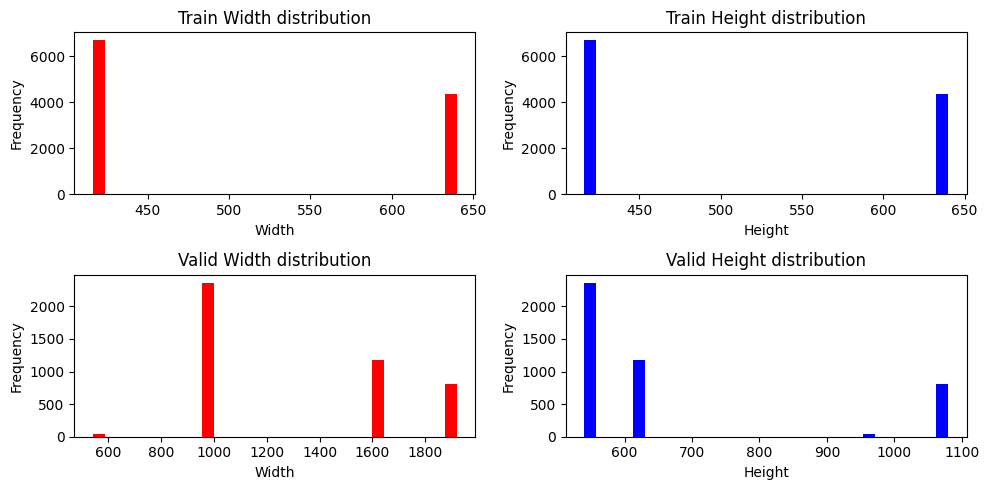

In [41]:
# plot width and height of image for train_df
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))

plt.subplot(2, 2, 1)
plt.hist(train_df['width'], bins=30, color='r')
plt.title('Train Width distribution')
plt.xlabel('Width')
plt.ylabel('Frequency')

plt.subplot(2, 2, 2)
plt.hist(train_df['height'], bins=30, color='b')
plt.title('Train Height distribution')
plt.xlabel('Height')
plt.ylabel('Frequency')

# plot width and height of image for valid_df
plt.subplot(2, 2, 3)
plt.hist(valid_df['width'], bins=30, color='r')
plt.title('Valid Width distribution')
plt.xlabel('Width')
plt.ylabel('Frequency')

plt.subplot(2, 2, 4)
plt.hist(valid_df['height'], bins=30, color='b')
plt.title('Valid Height distribution')
plt.xlabel('Height')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [42]:
# take 0.25 from valid_df add to train_df and keep 0.75 for valid_df
valid_sample=valid_df.sample(frac=0.25, random_state=42)
valid_remaining=valid_df.drop(valid_sample.index)

train_df = pd.concat([train_df, valid_sample], ignore_index=True)
valid_df = valid_remaining
train_df.shape, valid_df.shape

((12184, 5), (3290, 5))

In [43]:
def copy_data_from_df(df, output_folder, split='train'):
    # Đường dẫn đến thư mục đầu ra cho ảnh và nhãn
    output_images_folder = os.path.join(output_folder, split, 'images')
    output_labels_folder = os.path.join(output_folder, split, 'labels')
    
    output_images_folder=output_images_folder.replace('\\','/')
    output_labels_folder=output_labels_folder.replace('\\','/')

    # Duyệt qua từng dòng trong DataFrame
    for index, row in df.iterrows():
        # Đường dẫn đến ảnh và nhãn trong DataFrame
        src_image = row['image_path']
        src_label = row['label_path']
        filename = row['filename']

        # Đường dẫn đến file đích trong thư mục đầu ra
        dst_image = os.path.join(output_images_folder, filename)
        dst_label = os.path.join(output_labels_folder, os.path.splitext(filename)[0] + '.txt')
        
        dst_image=dst_image.replace('\\','/')
        dst_label=dst_label.replace('\\','/')
        
        # create folder if not exist
        os.makedirs(os.path.dirname(dst_image), exist_ok=True)
        os.makedirs(os.path.dirname(dst_label), exist_ok=True)

        # Sao chép ảnh
        if os.path.exists(src_image):
            shutil.copy(src_image, dst_image)
        else:
            print(f"File ảnh không tồn tại: {src_image}")

        # Sao chép nhãn
        if os.path.exists(src_label):
            shutil.copy(src_label, dst_label)
        else:
            print(f"File nhãn không tồn tại: {src_label}")

In [44]:
test_df = valid_df.sample(frac=0.5, random_state=42)
valid_df = valid_df.drop(test_df.index)
train_df.shape, valid_df.shape, test_df.shape

((12184, 5), (1645, 5), (1645, 5))

In [45]:
copy_data_from_df(train_df, target_ouput, 'train')
copy_data_from_df(valid_df, target_ouput, 'valid')
copy_data_from_df(test_df, target_ouput, 'test')

In [46]:
train_df=read_image([f'{target_ouput}/train'])
valid_df=read_image([f'{target_ouput}/valid'])
test_df=read_image([f'{target_ouput}/test'])

1
Đọc hình ảnh từ: ../dataset/detection/train
1
Đọc hình ảnh từ: ../dataset/detection/valid
1
Đọc hình ảnh từ: ../dataset/detection/test


In [8]:
train_df.head(3)

,filename,image_path,label_path,width,height
0,000000_jpg.rf.9c2d93c681b7d38d50bf4f096a6baf03...,../dataset/detection/train/images/000000_jpg.r...,../dataset/detection/train/labels/000000_jpg.r...,416,416
1,000000_jpg.rf.b11f308f16626f9f795a148029c46d10...,../dataset/detection/train/images/000000_jpg.r...,../dataset/detection/train/labels/000000_jpg.r...,416,416
2,000001_jpg.rf.4f8eac6747a989e40bff9c86bc5d97be...,../dataset/detection/train/images/000001_jpg.r...,../dataset/detection/train/labels/000001_jpg.r...,416,416


In [9]:
valid_df.head(3)

,filename,image_path,label_path,width,height
0,0002.jpg,../dataset/detection/valid/images/0002.jpg,../dataset/detection/valid/labels/0002.txt,960,540
1,0003.jpg,../dataset/detection/valid/images/0003.jpg,../dataset/detection/valid/labels/0003.txt,960,540
2,0004.jpg,../dataset/detection/valid/images/0004.jpg,../dataset/detection/valid/labels/0004.txt,960,540


In [10]:
test_df.head(3) 

,filename,image_path,label_path,width,height
0,0001.jpg,../dataset/detection/test/images/0001.jpg,../dataset/detection/test/labels/0001.txt,640,640
1,0007.jpg,../dataset/detection/test/images/0007.jpg,../dataset/detection/test/labels/0007.txt,640,640
2,0008.jpg,../dataset/detection/test/images/0008.jpg,../dataset/detection/test/labels/0008.txt,640,640


In [20]:
import cv2
import numpy as np

def resize_and_save(image_path, label_path, new_size=(640,640)):
    # Đọc ảnh
    image = cv2.imread(image_path)
    original_height, original_width = image.shape[:2]

    # Resize ảnh
    resized_image = cv2.resize(image, new_size)
    new_width, new_height = new_size

    # Đọc file label
    with open(label_path, 'r') as file:
        lines = file.readlines()

    # Điều chỉnh bounding box
    new_lines = []
    for line in lines:
        class_id, x_center, y_center, width, height = map(float, line.split())

        # Tính toán tỷ lệ resize
        x_scale = new_width / original_width
        y_scale = new_height / original_height

        # Điều chỉnh tọa độ và kích thước bounding box
        new_x_center = x_center * x_scale
        new_y_center = y_center * y_scale
        new_width_box = width * x_scale
        new_height_box = height * y_scale

        # Chuẩn hóa lại tọa độ và kích thước về [0, 1]
        new_x_center /= new_width
        new_y_center /= new_height
        new_width_box /= new_width
        new_height_box /= new_height

        # Ghi lại thông tin bounding box mới
        new_lines.append(f"{int(class_id)} {new_x_center:.6f} {new_y_center:.6f} {new_width_box:.6f} {new_height_box:.6f}\n")

    # Lưu ảnh đã resize
    cv2.imwrite(image_path, resized_image)

    # Lưu file label mới
    with open(label_path, 'w') as file:
        file.writelines(new_lines)



In [21]:
# resize image and save to target folder
for index, row in train_df.iterrows():
    resize_and_save(row['image_path'], row['label_path'])
print('Train data done')
for index, row in valid_df.iterrows():
    resize_and_save(row['image_path'], row['label_path'])
print('Valid data done')
for index, row in test_df.iterrows():
    resize_and_save(row['image_path'], row['label_path'])
print('Test data done')

In [22]:
train_df=read_image([f'{target_ouput}/train'])
valid_df=read_image([f'{target_ouput}/valid'])
test_df=read_image([f'{target_ouput}/test'])

1
Đọc hình ảnh từ: ../dataset/detection/train
1
Đọc hình ảnh từ: ../dataset/detection/valid
1
Đọc hình ảnh từ: ../dataset/detection/test


In [23]:
train_df.head(3)

,filename,image_path,label_path,width,height
0,000000_jpg.rf.9c2d93c681b7d38d50bf4f096a6baf03...,../dataset/detection/train/images/000000_jpg.r...,../dataset/detection/train/labels/000000_jpg.r...,640,640
1,000000_jpg.rf.b11f308f16626f9f795a148029c46d10...,../dataset/detection/train/images/000000_jpg.r...,../dataset/detection/train/labels/000000_jpg.r...,640,640
2,000001_jpg.rf.4f8eac6747a989e40bff9c86bc5d97be...,../dataset/detection/train/images/000001_jpg.r...,../dataset/detection/train/labels/000001_jpg.r...,640,640


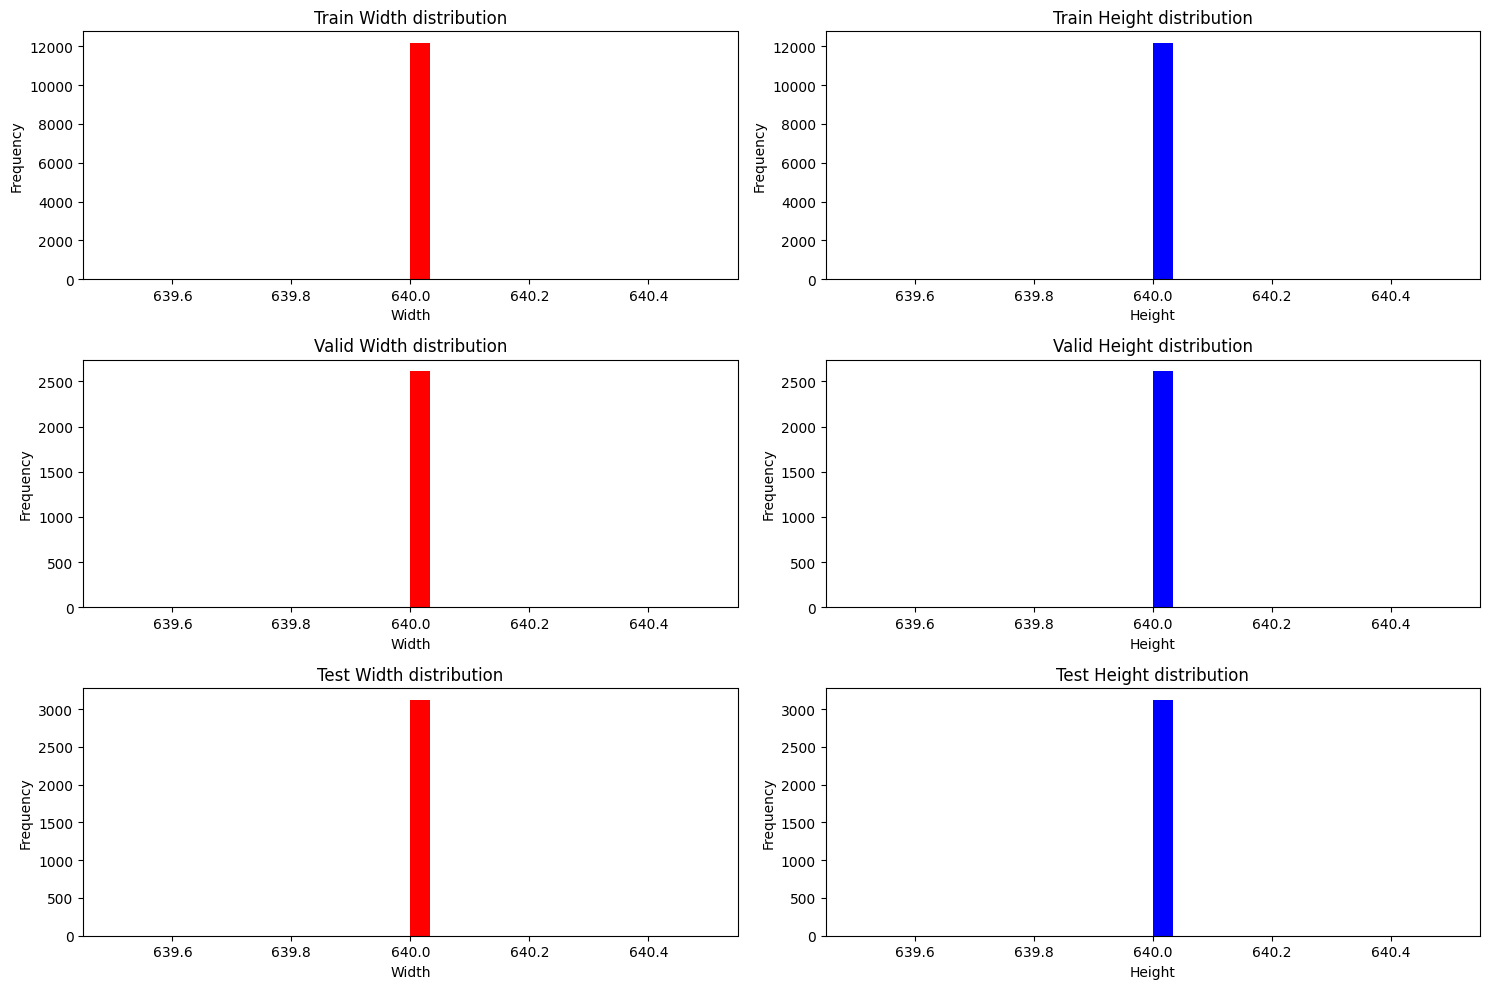

In [24]:
# plot width and height of image for train_df, valid_df, and test_df
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 10))

plt.subplot(3, 2, 1)
plt.hist(train_df['width'], bins=30, color='r')
plt.title('Train Width distribution')
plt.xlabel('Width')
plt.ylabel('Frequency')

plt.subplot(3, 2, 2)
plt.hist(train_df['height'], bins=30, color='b')
plt.title('Train Height distribution')
plt.xlabel('Height')
plt.ylabel('Frequency')

plt.subplot(3, 2, 3)
plt.hist(valid_df['width'], bins=30, color='r')
plt.title('Valid Width distribution')
plt.xlabel('Width')
plt.ylabel('Frequency')

plt.subplot(3, 2, 4)
plt.hist(valid_df['height'], bins=30, color='b')
plt.title('Valid Height distribution')
plt.xlabel('Height')
plt.ylabel('Frequency')

plt.subplot(3, 2, 5)
plt.hist(test_df['width'], bins=30, color='r')
plt.title('Test Width distribution')
plt.xlabel('Width')
plt.ylabel('Frequency')

plt.subplot(3, 2, 6)
plt.hist(test_df['height'], bins=30, color='b')
plt.title('Test Height distribution')
plt.xlabel('Height')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [25]:
for index, row in train_df.iterrows():
    draw_bbox(row['image_path'], row['label_path'])
print('Train data done')
for index, row in valid_df.iterrows():
    draw_bbox(row['image_path'], row['label_path'])
print('Valid data done')
for index, row in test_df.iterrows():
    draw_bbox(row['image_path'], row['label_path'])
print('Test data done')

Train data done
Valid data done
Test data done
